In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import AutoTokenizer, AutoModel
import torch
import joblib
import random
from tqdm import tqdm
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Set seed for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)


In [12]:
# Load the labeled dataset
labeled_df = pd.read_csv('Stormfront_labeled.csv')
print("Labeled dataset loaded. Shape:", labeled_df.shape)

# Extract relevant columns
labeled_df = labeled_df[['Message', 'CM', 'AOPV', 'CDACT', 'TI', 'TTBF']]
print("Relevant columns from labeled dataset extracted. Shape:", labeled_df.shape)


Labeled dataset loaded. Shape: (491, 42)
Relevant columns from labeled dataset extracted. Shape: (491, 6)


In [13]:
# Load the unlabeled dataset in chunks and concatenate the required number of rows
chunk_size = 100000  # Adjust chunk size as needed
target_unlabeled_size = 60000  # Increased target size for testing
chunks = []

for chunk in pd.read_csv('cleanposts.csv', chunksize=chunk_size):
    # Filter out non-English messages
    chunk = chunk[chunk['lang'] == 'en']
    chunks.append(chunk[['cleanmessage']].rename(columns={'cleanmessage': 'Message'}))
    
    # Check if we have reached the target size
    if sum(len(c) for c in chunks) >= target_unlabeled_size:
        break

unlabeled_df = pd.concat(chunks).head(target_unlabeled_size)
print("Unlabeled dataset loaded and sampled. Shape:", unlabeled_df.shape)


Unlabeled dataset loaded and sampled. Shape: (60000, 1)


In [14]:
from sklearn.metrics import make_scorer
from sklearn.metrics.pairwise import cosine_similarity

# Custom scoring function for TF-IDF Vectorizer
def tfidf_scorer(estimator, X):
    X_transformed = estimator.transform(X)
    score = np.mean(cosine_similarity(X_transformed))
    return score

# Define a function to manually perform TF-IDF Vectorization with hyperparameter tuning
def tune_tfidf_vectorizer(texts):
    param_grid = {
        'max_features': [5000, 10000],
        'ngram_range': [(1, 1), (1, 2)],
        'min_df': [5, 10],
        'max_df': [0.85, 0.9]
    }
    tfidf = TfidfVectorizer()
    grid_search = GridSearchCV(tfidf, param_grid, cv=3, n_jobs=-1, verbose=2, scoring=make_scorer(tfidf_scorer))
    grid_search.fit(texts)  # Only fit on texts
    return grid_search.best_estimator_

# Perform TF-IDF Vectorization with tuning on the labeled dataset
tfidf_vectorizer = tune_tfidf_vectorizer(labeled_df['Message'])
tfidf_features_labeled = tfidf_vectorizer.fit_transform(labeled_df['Message']).toarray()
tfidf_features_unlabeled = tfidf_vectorizer.transform(unlabeled_df['Message']).toarray()


Fitting 3 folds for each of 16 candidates, totalling 48 fits


/Users/aryan/anaconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:43: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

/Users/aryan/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/aryan/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/aryan/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/aryan/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/aryan/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas require

[CV] END max_df=0.85, max_features=5000, min_df=10, ngram_range=(1, 1); total time=   0.0s
[CV] END max_df=0.85, max_features=5000, min_df=5, ngram_range=(1, 1); total time=   0.1s
[CV] END max_df=0.85, max_features=5000, min_df=5, ngram_range=(1, 1); total time=   0.1s
[CV] END max_df=0.85, max_features=5000, min_df=5, ngram_range=(1, 1); total time=   0.1s
[CV] END max_df=0.85, max_features=5000, min_df=10, ngram_range=(1, 1); total time=   0.1s
[CV] END max_df=0.85, max_features=5000, min_df=10, ngram_range=(1, 1); total time=   0.1s
[CV] END max_df=0.85, max_features=10000, min_df=5, ngram_range=(1, 1); total time=   0.1s
[CV] END max_df=0.85, max_features=10000, min_df=5, ngram_range=(1, 1); total time=   0.1s
[CV] END max_df=0.85, max_features=10000, min_df=5, ngram_range=(1, 1); total time=   0.1s


/Users/aryan/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/aryan/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/Users/aryan/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/aryan/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_tr

[CV] END max_df=0.85, max_features=5000, min_df=5, ngram_range=(1, 2); total time=   0.3s
[CV] END max_df=0.85, max_features=10000, min_df=10, ngram_range=(1, 1); total time=   0.1s
[CV] END max_df=0.85, max_features=10000, min_df=10, ngram_range=(1, 1); total time=   0.1s
[CV] END max_df=0.85, max_features=10000, min_df=10, ngram_range=(1, 1); total time=   0.1s
[CV] END max_df=0.85, max_features=5000, min_df=10, ngram_range=(1, 2); total time=   0.3s
[CV] END max_df=0.85, max_features=5000, min_df=10, ngram_range=(1, 2); total time=   0.3s
[CV] END max_df=0.85, max_features=5000, min_df=5, ngram_range=(1, 2); total time=   0.3s
[CV] END max_df=0.85, max_features=5000, min_df=5, ngram_range=(1, 2); total time=   0.3s
[CV] END max_df=0.85, max_features=5000, min_df=10, ngram_range=(1, 2); total time=   0.3s
[CV] END max_df=0.85, max_features=10000, min_df=5, ngram_range=(1, 2); total time=   0.2s
[CV] END max_df=0.85, max_features=10000, min_df=5, ngram_range=(1, 2); total time=   0.2s

/Users/aryan/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


In [15]:
# Initialize tokenizer and model for feature extraction
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
distilbert_model = AutoModel.from_pretrained('distilbert-base-uncased')

def get_bert_features(texts, tokenizer, model, batch_size=32):
    features = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Extracting BERT Features"):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts, return_tensors='pt', padding=True, truncation=True, max_length=256)
        with torch.no_grad():
            outputs = model(**inputs)
        batch_features = outputs.last_hidden_state.mean(dim=1).numpy()
        features.append(batch_features)
    return np.vstack(features)

# Extract BERT features
bert_features_labeled = get_bert_features(labeled_df['Message'].tolist(), tokenizer, distilbert_model)
bert_features_unlabeled = get_bert_features(unlabeled_df['Message'].tolist(), tokenizer, distilbert_model)


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Extracting BERT Features: 100%|██████████| 1875/1875 [2:03:41<00:00,  3.96s/it]  


In [16]:
# Combine TF-IDF and BERT features
labeled_features = np.hstack([tfidf_features_labeled, bert_features_labeled])
unlabeled_features = np.hstack([tfidf_features_unlabeled, bert_features_unlabeled])

# Convert to DataFrame for compatibility with model training
labeled_features_df = pd.DataFrame(labeled_features)
unlabeled_features_df = pd.DataFrame(unlabeled_features)

# Add target columns to the labeled features DataFrame
labeled_features_df[['CM', 'AOPV', 'CDACT', 'TI', 'TTBF']] = labeled_df[['CM', 'AOPV', 'CDACT', 'TI', 'TTBF']]
# Split the labeled data into training and validation sets
train_df, val_df = train_test_split(labeled_features_df, test_size=0.2, random_state=42)
print(f"Training data shape: {train_df.shape}, Validation data shape: {val_df.shape}")

# Save train and validation data to disk
train_df.to_csv('train_df.csv', index=False)
val_df.to_csv('val_df.csv', index=False)


Training data shape: (392, 1681), Validation data shape: (99, 1681)


In [17]:
# Define the parameter grids for the models
param_grid_rf = {
    'estimator__n_estimators': [100, 200, 300],
    'estimator__max_depth': [None, 10, 20],
    'estimator__min_samples_split': [2, 5, 10],
    'estimator__min_samples_leaf': [1, 2, 4],
    'estimator__max_features': ['sqrt', 'log2', None]
}

param_grid_gb = {
    'estimator__n_estimators': [100, 200, 300],
    'estimator__max_depth': [3, 5, 7],
    'estimator__learning_rate': [0.01, 0.05, 0.1]
}

# Initialize the models
rf_model = MultiOutputRegressor(RandomForestRegressor(random_state=42))
gb_model = MultiOutputRegressor(GradientBoostingRegressor(random_state=42))

# Initialize RandomizedSearchCV for hyperparameter tuning
rf_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid_rf, n_iter=20, cv=3, n_jobs=-1, random_state=42, verbose=2)
gb_search = RandomizedSearchCV(estimator=gb_model, param_distributions=param_grid_gb, n_iter=20, cv=3, n_jobs=-1, random_state=42, verbose=2)

# Load training data from disk
train_df = pd.read_csv('train_df.csv')
X_train = train_df.iloc[:, :-5]
y_train = train_df.iloc[:, -5:].values  # Ensure y_train is a 2D array

print("Starting RandomizedSearchCV for RandomForestRegressor...")
rf_search.fit(X_train, y_train)
print("RandomForestRegressor best parameters:", rf_search.best_params_)

print("Starting RandomizedSearchCV for GradientBoostingRegressor...")
gb_search.fit(X_train, y_train)
print("GradientBoostingRegressor best parameters:", gb_search.best_params_)

# Update the models with best parameters
rf_model = rf_search.best_estimator_
gb_model = gb_search.best_estimator_

# Initialize MultiOutputRegressor for each base model with best parameters
rf_multioutput = rf_model
gb_multioutput = gb_model

# Fit the MultiOutputRegressor models
print("Fitting MultiOutputRegressor for RandomForestRegressor...")
rf_multioutput.fit(X_train, y_train)

print("Fitting MultiOutputRegressor for GradientBoostingRegressor...")
gb_multioutput.fit(X_train, y_train)


Starting RandomizedSearchCV for RandomForestRegressor...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/Users/aryan/anaconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:43: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

/Users/aryan/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/aryan/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/aryan/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/aryan/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/aryan/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas require

[CV] END estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=100; total time=   3.1s
[CV] END estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=100; total time=   3.1s
[CV] END estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=100; total time=   3.1s
[CV] END estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=100; total time=   3.8s
[CV] END estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=100; total time=   3.8s
[CV] END estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__mi

MultiOutputRegressor(estimator=GradientBoostingRegressor(learning_rate=0.05,
                                                         n_estimators=300,
                                                         random_state=42))

In [18]:
# Custom Stacking Regressor for MultiOutput
class CustomMultiOutputStackingRegressor:
    def __init__(self, estimators, final_estimator, cv=5, n_jobs=None):
        self.estimators = estimators
        self.final_estimator = final_estimator
        self.cv = cv
        self.n_jobs = n_jobs
        self.multi_output_estimators = [MultiOutputRegressor(estimator) for name, estimator in estimators]

    def fit(self, X, y):
        self.multi_output_estimators_ = [estimator.fit(X, y) for estimator in self.multi_output_estimators]
        meta_features = np.column_stack([estimator.predict(X) for estimator in self.multi_output_estimators_])
        self.final_estimator_ = MultiOutputRegressor(self.final_estimator).fit(meta_features, y)
        return self

    def predict(self, X):
        meta_features = np.column_stack([estimator.predict(X) for estimator in self.multi_output_estimators_])
        return self.final_estimator_.predict(meta_features)

# Define the stacking regressor
stacking_regressor = CustomMultiOutputStackingRegressor(
    estimators=[
        ('rf', rf_model.estimator),
        ('gb', gb_model.estimator)
    ],
    final_estimator=RidgeCV(),
    cv=5,
    n_jobs=-1
)

stacking_regressor.fit(X_train, y_train)


In [19]:
# Evaluate the stacking regressor
val_df = pd.read_csv('val_df.csv')
X_val = val_df.iloc[:, :-5]
y_val = val_df.iloc[:, -5:].values  # Ensure y_val is a 2D array

val_predictions = stacking_regressor.predict(X_val)

val_mse = mean_squared_error(y_val, val_predictions, multioutput='uniform_average')
val_r2 = r2_score(y_val, val_predictions, multioutput='uniform_average')
val_mae = mean_absolute_error(y_val, val_predictions, multioutput='uniform_average')
print(f'Stacking Regressor Validation MSE: {val_mse}')
print(f'Stacking Regressor Validation R2: {val_r2}')
print(f'Stacking Regressor Validation MAE: {val_mae}')

# Save the trained stacking regressor
joblib.dump(stacking_regressor, 'stacking_regressor_model.pkl')
print("Trained stacking regressor model saved as 'stacking_regressor_model.pkl'.")


Stacking Regressor Validation MSE: 0.6814409466584493
Stacking Regressor Validation R2: 0.4230727689734133
Stacking Regressor Validation MAE: 0.5682165346332988
Trained stacking regressor model saved as 'stacking_regressor_model.pkl'.


# Visuals

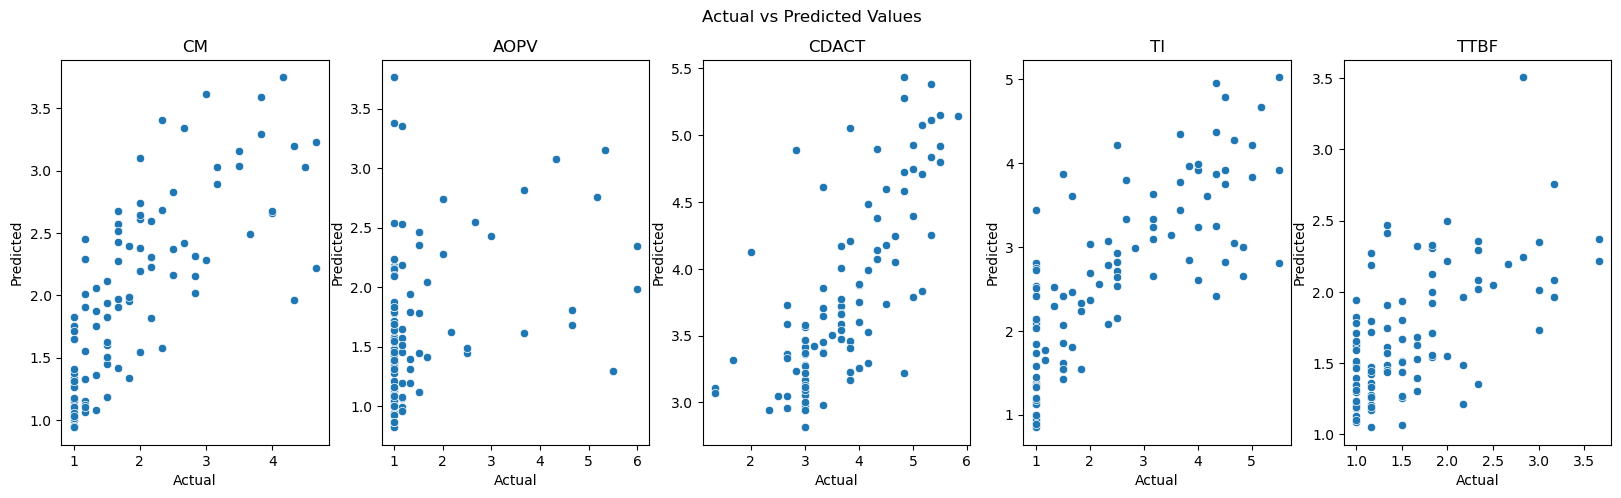

/Users/aryan/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/aryan/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/aryan/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/aryan/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Conver

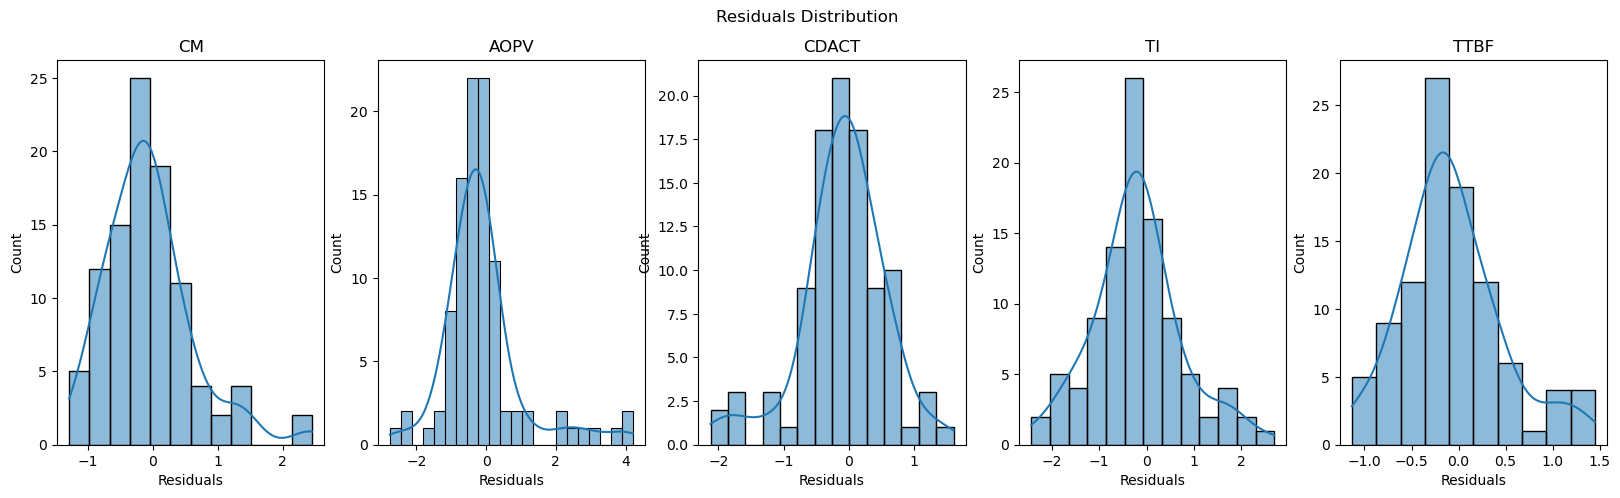

Presentation content generated and saved as 'presentation_content.md'.


In [24]:
# Define target names
target_names = ['CM', 'AOPV', 'CDACT', 'TI', 'TTBF']

# Function to plot actual vs predicted values
def plot_actual_vs_predicted(y_actual, y_predicted, target_names, title):
    fig, axs = plt.subplots(1, y_actual.shape[1], figsize=(20, 5))
    fig.suptitle(title)
    for i in range(y_actual.shape[1]):
        sns.scatterplot(x=y_actual[:, i], y=y_predicted[:, i], ax=axs[i])
        axs[i].set_xlabel('Actual')
        axs[i].set_ylabel('Predicted')
        axs[i].set_title(f'{target_names[i]}')
    plt.show()

# Function to plot residuals
def plot_residuals(y_actual, y_predicted, target_names, title):
    fig, axs = plt.subplots(1, y_actual.shape[1], figsize=(20, 5))
    fig.suptitle(title)
    for i in range(y_actual.shape[1]):
        residuals = y_actual[:, i] - y_predicted[:, i]
        sns.histplot(residuals, kde=True, ax=axs[i])
        axs[i].set_xlabel('Residuals')
        axs[i].set_title(f'{target_names[i]}')
    plt.show()

# Predict on validation set
val_predictions = stacking_regressor.predict(X_val)

# Visualize actual vs predicted values
plot_actual_vs_predicted(y_val, val_predictions, target_names, 'Actual vs Predicted Values')

# Visualize residuals
plot_residuals(y_val, val_predictions, target_names, 'Residuals Distribution')